# **Real** vs **Fake** face detection using Keras

This project aims to discriminate between **fake** images and **real** ones. This dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) that was provided by Bojan.

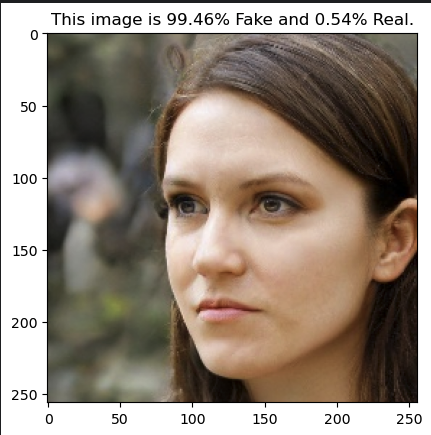

The project will include also the **Grad-cam** visualization to understand why a deep learning network makes its classification decisions.

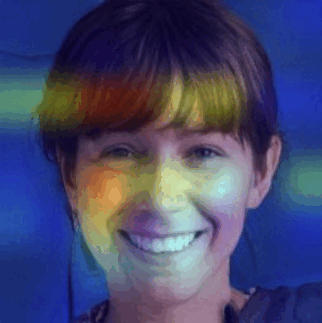

# Main Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
tf.keras.backend.clear_session() #clean session

# Data Loading

The paths to the training, validation, and test sets have been specified below.

In [3]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [4]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis

Create a dictionary with three keys:
* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)    

In [5]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [6]:
images_df = pd.DataFrame(images_df)

In [7]:
images_df

folder                                         image_path label
0       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
1       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
2       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
3       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
4       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
...       ...                                                ...   ...
139995  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139996  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139997  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139998  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139999  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real

[140000 rows x 3 columns]

### Labels distribution

In [8]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [9]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [10]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

As we can see fromt the results, the labels are equally distributed on each folder.

# Data Preparation for visualization and training

## Data Augmentation

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. Horizontal flip data augmentation is set to True in order to increase the size of a dataset by flipping images horizontally. This can help improve the accuracy of the model by exposing it to additional variations of the same images.

In [11]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

Important! test_ds prediction and train_ds.classes (ground-truth) **will be not alligned** with suffle=True, so I need to disable shuffle for the test set.

In [12]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [13]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

# Data Visualization

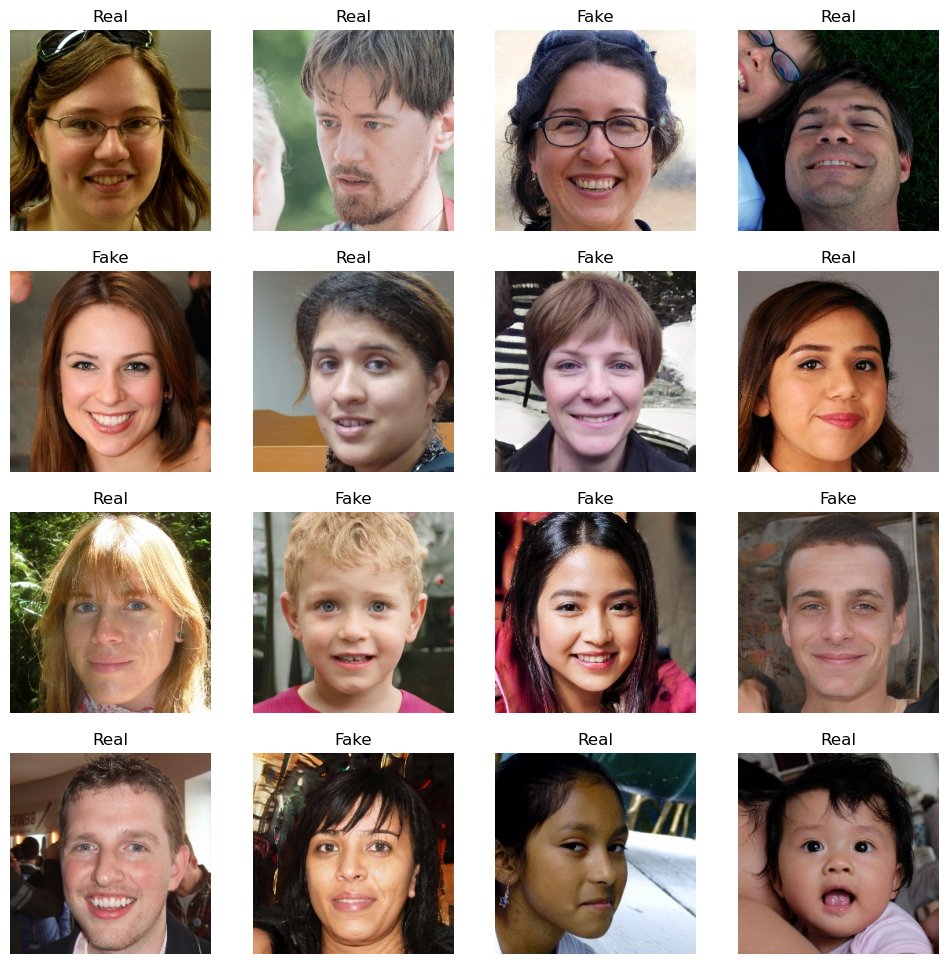

In [14]:
img,lbl = next(train_ds)
plot_images(img,lbl)


It's visible that all the value are scaled.

In [15]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.1254902  0.15294118 0.1764706 ]
  [0.1254902  0.15294118 0.1764706 ]
  [0.1254902  0.15294118 0.1764706 ]
  ...
  [0.1137255  0.14901961 0.18431373]
  [0.10980393 0.14509805 0.18039216]
  [0.10588236 0.14117648 0.1764706 ]]

 [[0.13333334 0.16078432 0.18431373]
  [0.12941177 0.15686275 0.18039216]
  [0.1254902  0.15294118 0.1764706 ]
  ...
  [0.1137255  0.14901961 0.18431373]
  [0.10980393 0.14509805 0.18039216]
  [0.10588236 0.14117648 0.1764706 ]]

 [[0.13333334 0.16078432 0.18431373]
  [0.12941177 0.15686275 0.18039216]
  [0.1254902  0.15294118 0.1764706 ]
  ...
  [0.10980393 0.14509805 0.18039216]
  [0.10980393 0.14509805 0.18039216]
  [0.10588236 0.14117648 0.1764706 ]]

 ...

 [[0.19607845 0.19215688 0.21176472]
  [0.18431373 0.18823531 0.19607845]
  [0.18431373 0.18039216 0.20000002]
  ...
  [0.87843144 0.87843144 0.87843144]
  [0.8705883  0.8705883  0.8705883 ]
  [0.8705883  0.8705883  0.8705883 ]]

 [[0.23529413 0.227451   0.2392157 ]
  [0.227451   0.227451   0.2

Let's print the input shape:
- 32 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [16]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [17]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# CNN model architecture (DenseNet121)

In [18]:
input_shape = (256, 256, 3) #define the input shape of our data

In [ ]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output) 

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [20]:
model_ft = get_model(input_shape)

model_ft.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

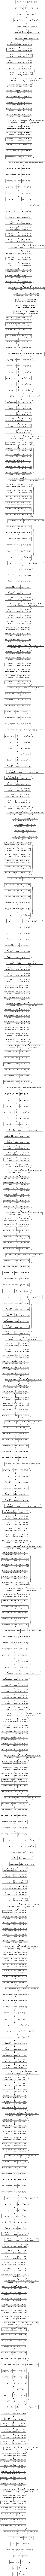

In [21]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

Let's define the Callbacks

**ModelCheckpoint** callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
In this case, we don't have to worry about training for too long and overfitting the training set.

In [22]:
checkpoint_filepath = "/kaggle/working/model_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

The **EarlyStopping** callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [23]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau** callback reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

# Training

In [25]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10
1563/1563 [==============================] - 1064s 631ms/step - loss: 0.1300 - accuracy: 0.9476 - val_loss: 0.8141 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 2/10
1563/1563 [==============================] - 748s 478ms/step - loss: 0.0530 - accuracy: 0.9804 - val_loss: 0.0734 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 3/10
1563/1563 [==============================] - 745s 476ms/step - loss: 0.0389 - accuracy: 0.9857 - val_loss: 0.6014 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 4/10
1563/1563 [==============================] - 747s 478ms/step - loss: 0.0352 - accuracy: 0.9872 - val_loss: 0.2214 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 5/10
1563/1563 [==============================] - 737s 471ms/step - loss: 0.0284 - accuracy: 0.9897 - val_loss: 0.0597 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 6/10
1563/1563 [==============================] - 748s 479ms/step - loss: 0.0261 - accuracy: 0.9904 - val_loss: 0.5788 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 7/10
1563/1563 [===========

# Results

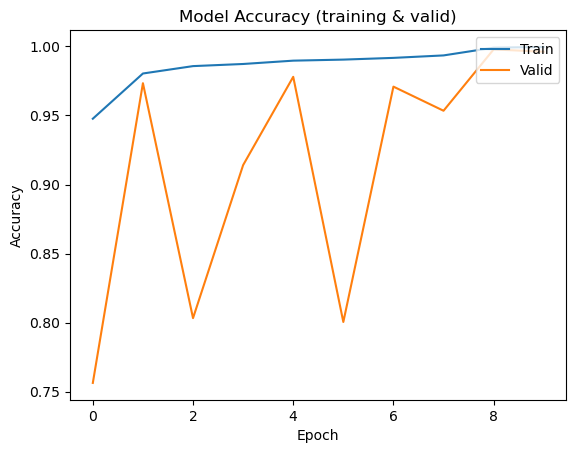

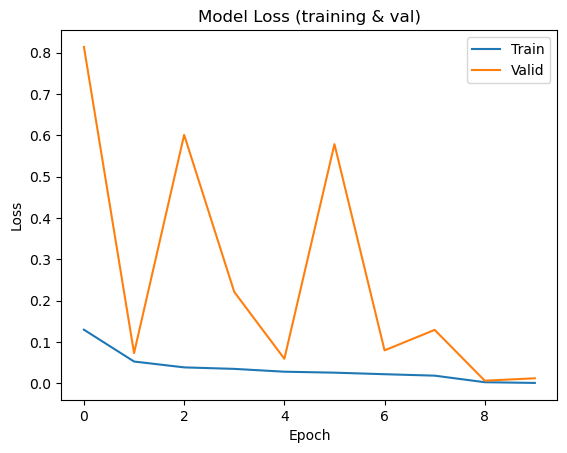

In [26]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

The model is clearly overfitted. So wee have to restore the model weights from the ModelCheckpoint callback.

Let's try to evaluate the full overfitted model. We can see that it has a poor performance.

In [27]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 155s 497ms/step - loss: 0.0114 - accuracy: 0.9963
Test Loss: 0.011353960260748863
Test Accuracy: 0.9962999820709229


Here a ModelCheckpoint callback is necessary. Indeed loading the best weights results in a much better performance on the test set.

In [28]:
model = get_model(input_shape)

# Restore the weights
model.load_weights('/kaggle/working/model_cp.h5')


In [29]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 74s 227ms/step - loss: 0.0071 - accuracy: 0.9973
Test Loss: 0.007072466425597668
Test Accuracy: 0.9973499774932861


In [30]:
model.save('/kaggle/output/model_densenet.h5')

# Image example - Qualitative results

Let's try the model on a real image. It is very confident (99.96%) that it is a real one.

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

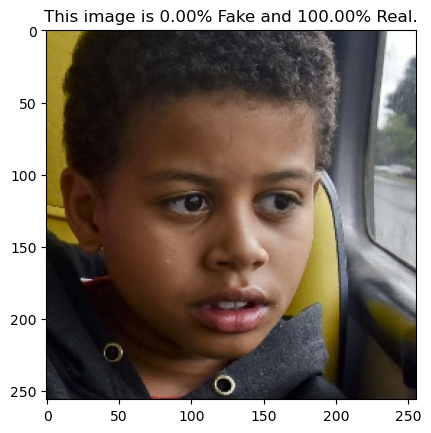

In [31]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


The result score is near 1 if the image is **real** and 0 if the image is **fake**.

1/1 [==============================] - 0s 29ms/step


Text(0.5, 1.0, 'This image is 100.00% Fake and 0.00% Real.')

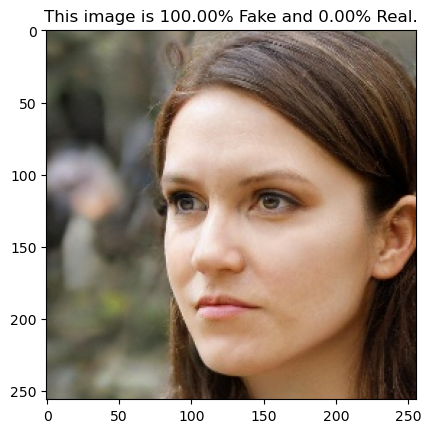

In [32]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

#fake example
test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

# Quantitative results

In [33]:
# Assuming you have defined your model as 'model'
predicted_labels = model.predict(test_ds)

313/313 [==============================] - 71s 221ms/step


In [34]:
true_labels = test_ds.classes

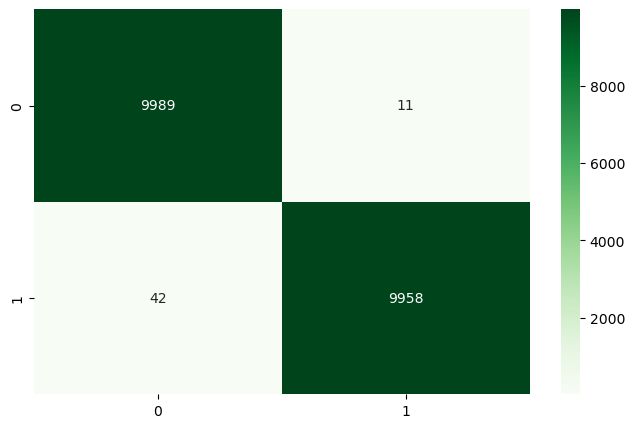

In [35]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [36]:
metrics.accuracy_score(true_labels, predicted_labels.round())

0.99735

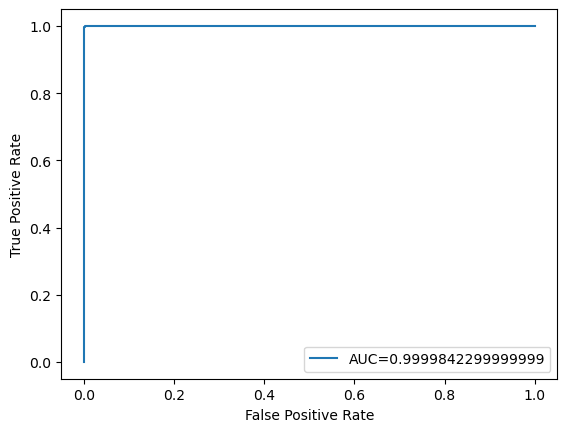

In [37]:
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [44]:
import os

# Create the output directory if it doesn't exist
os.makedirs('/kaggle/output/', exist_ok=True)

# Save the model
model.save('/kaggle/output/model_densenet.h5')


# Grad-cam class activation visualization

This example shows how to use the gradient-weighted class activation mapping (Grad-CAM) technique to understand why a deep learning network makes its classification decisions. Grad-CAM, invented by Selvaraju and coauthors, uses the gradient of the classification score with respect to the convolutional features determined by the network in order to understand which parts of the image are most important for classification.

Lot of the following code is from https://keras.io/examples/vision/grad_cam/

In [46]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras

In [47]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [48]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [49]:
# Get the names of all layers in the model.
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

input_2
zero_padding2d_2
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_3
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

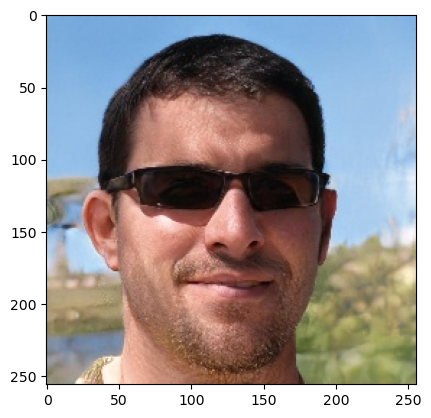

In [50]:

img_size = (256, 256)


last_conv_layer_name = "conv5_block16_1_conv"

img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00PB1BNIE8.jpg'

test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
plt.imshow(test_image)

img = tf.keras.preprocessing.image.img_to_array(test_image)
img = np.expand_dims(img, axis=0)
img = img/255.


1/1 [==============================] - 0s 31ms/step
Predicted: [[0.00198273]]


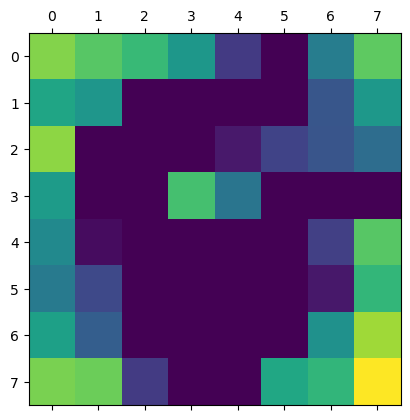

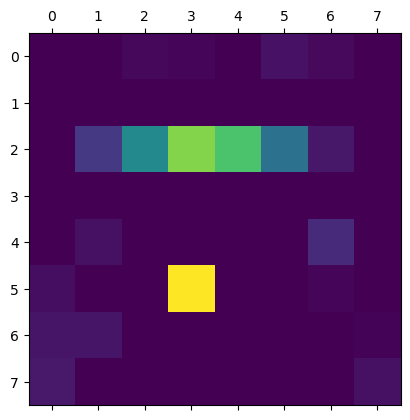

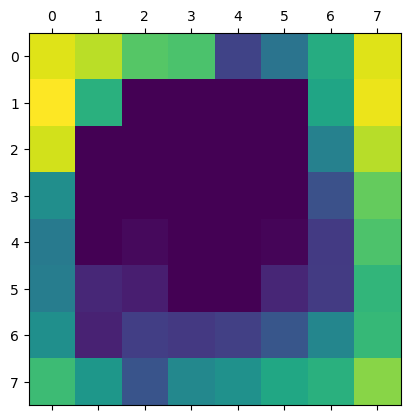

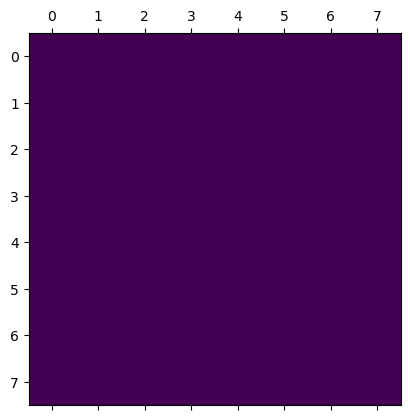

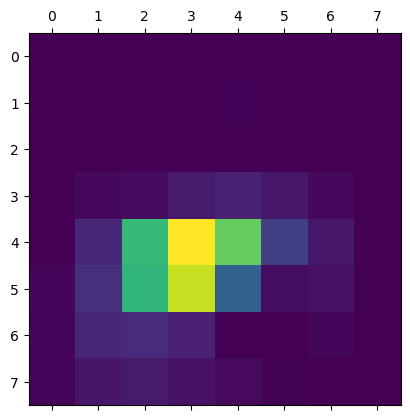

In [51]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, "conv5_block16_1_conv")
heatmap_2 = make_gradcam_heatmap(img, model, "conv5_block16_2_conv")
heatmap_3 = make_gradcam_heatmap(img, model, "conv5_block15_1_conv")
heatmap_4 = make_gradcam_heatmap(img, model, "conv5_block14_1_conv")
heatmap_5 = make_gradcam_heatmap(img, model, "conv5_block13_2_conv")

# Display heatmap
plt.matshow(heatmap)
plt.matshow(heatmap_2)
plt.matshow(heatmap_3)
plt.matshow(heatmap_4)
plt.matshow(heatmap_5)
plt.show()

# Grad-CAM Explains Why

The Grad-CAM technique utilizes the gradients of the classification score with respect to the final convolutional feature map, to identify the parts of an input image that most impact the classification score. The places where this gradient is large are exactly the places where the final score depends most on the data.

The gradCAM function computes the importance map by taking the derivative of the reduction layer output for a given class with respect to a convolutional feature map. For classification tasks, the gradCAM function automatically selects suitable layers to compute the importance map for. You can also specify the layers with the 'ReductionLayer' and 'FeatureLayer' name-value arguments.

 The 'jet' colormap has deep blue as the lowest value and deep red as the highest.

/tmp/ipykernel_32/1896598370.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


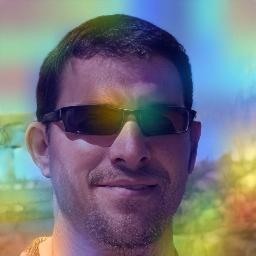

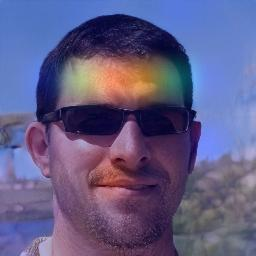

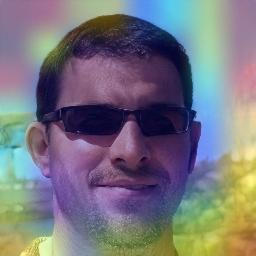

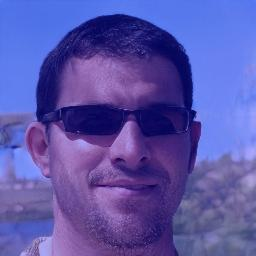

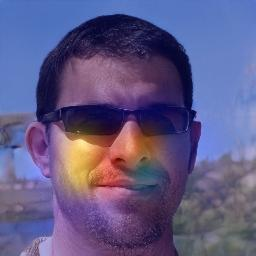

In [52]:
save_and_display_gradcam(img_path, heatmap)
save_and_display_gradcam(img_path, heatmap_2)
save_and_display_gradcam(img_path, heatmap_3)
save_and_display_gradcam(img_path, heatmap_4)
save_and_display_gradcam(img_path, heatmap_5)

# CNN model architecture (Xception)

To be continued.

In [54]:
#create the model's architecture and compile it
def get_xcp_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    xception = tf.keras.applications.Xception( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(xception.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(xception.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


83683744/83683744 [==============================] - 0s 0us/step


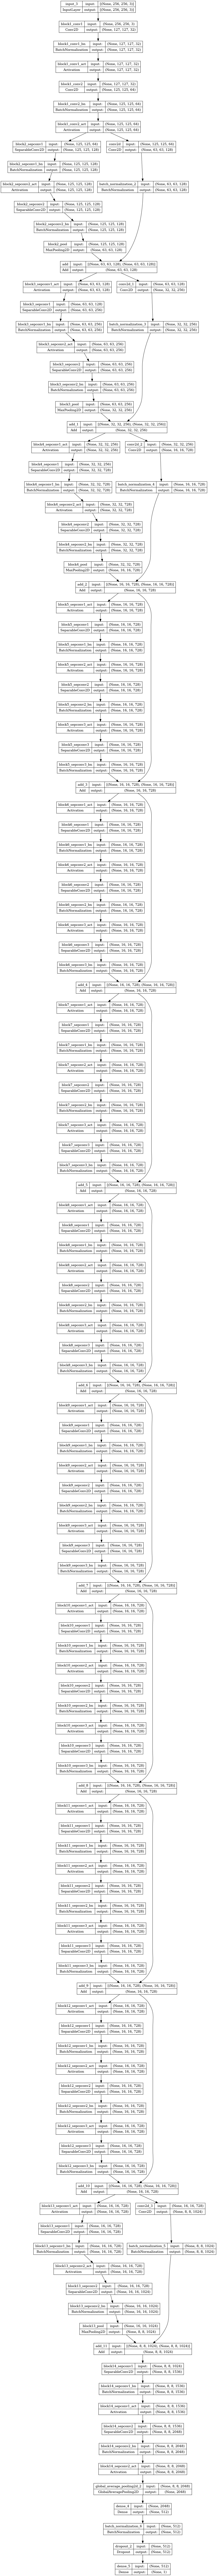

In [55]:
xcp_model = get_xcp_model(input_shape)

tf.keras.utils.plot_model(xcp_model, show_shapes=True)

In [ ]:
checkpoint_filepath_xcp = "/kaggle/working/model_xcp.h5"

checkpoint_xcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_xcp,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

early_stopping_xcp = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

reduce_lr_xcp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [ ]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_xcp, early_stopping_xcp, reduce_lr_xcp])

In [ ]:
model.save('/kaggle/outputs/model_xception.h5')

# END :)